In [1]:
import numpy as np
from scipy.special import factorial, factorial2
from sympy.physics.wigner import wigner_9j, wigner_6j, wigner_3j
from itertools import product
from numba import prange

from moshinsky_way import set_moshinsky_brackets

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Test Moshinsky brackets

In [8]:
# Test that our Moshinsky brackets are correct (quite incomplete but oh well)

loaded_brackets = set_moshinsky_brackets(10, 10)

si = np.sqrt(1/2)
co = -si

def A(n, l):
    return (-1)**n * (factorial2(2*n) * factorial2(2*n + 2*l + 1))**(-1/2)


In [38]:

# l1 = 0
# l2 = 0
# n1 = 0
# n2 = 0
# lamb = 0

count = 0
for l1, l2 in product(range(0, 4), repeat=2):
    for n1, n2 in product(range(0, 4), repeat=2):
        for lamb in range(np.abs(l1-l2), l1+l2+1):
        
            Nq = 2*n1 + l1 + 2*n2 + l2

            # if (l1 + l2) % 2 != 1:
            #     continue

            if (Nq - lamb) % 2 != 0:
                continue

            n_prime = (Nq - lamb)//2

            if 2*n_prime + lamb != Nq:
                print("WTF")

            bracket = float(co**(2*n1 + l1) * si**(2*n2 + l2) * (-1)**lamb * ((2*l1 + 1) * (2*l2 + 1))**(1/2) *\
                        wigner_3j(l1, l2, lamb, 0, 0, 0).evalf() * A(n1, l1) * A(n2, l2) / A(n_prime, lamb))


            loaded_bracket = loaded_brackets[n_prime, lamb, 0, 0, n1, l1, l2, lamb]
            loaded_bracket_2 = loaded_brackets[n1, l1, n2, l2, n_prime, lamb, 0, lamb]

            # if n1 == 0 and l1 == 0 and n2 == 0 and l2 == 0 and lamb == 0:
            #     print(bracket, loaded_bracket)

            if not np.isclose(loaded_bracket, loaded_bracket_2, atol=1e-6):
                print("WTF")
                print(loaded_bracket, loaded_bracket_2)

            if not np.isclose(bracket, loaded_bracket, atol=1e-6):
                print("Error in Moshinsky brackets:", n1, l1, n2, l2, n_prime, lamb)
                print(bracket, loaded_bracket)
                #print(A(n1, l1), A(n2, l2), A(n_prime, lamb), wigner_3j(l1, l2, lamb, 0, 0, 0).evalf())
                print("even" if (l1 + l2) % 2 == 0 else "odd")
                print(Nq)
            
            asym_bracket = loaded_brackets[n_prime, lamb, 0, 0, n2, l2, l1, lamb]
            if not np.isclose(bracket, -asym_bracket, atol=1e-6) and (l1 + l2) % 2 == 1:
                print("Swoop:", n1, l1, n2, l2, n_prime, lamb)
                print(bracket, asym_bracket)
                print("even" if (l1 + l2) % 2 == 0 else "odd")
                print(Nq)

            count += 1

print("COUNT:", count)

COUNT: 480


## Test the index flattener/unflattener

In [4]:
import full_minnesota_hf_system as hfs
import numpy as np
from itertools import product

system = hfs.System(Ne_max=4, l_max=1, hbar_omega=10, mass=939, include_m=False)

print("Num_sates:", system.num_states)
indices = np.arange(0, system.num_states)

unflattened = []
for idx in indices:
    unflatten = system.index_unflattener(idx)
    flatten = system.index_flattener(*unflatten)
    if idx != flatten:
        print("WTF")
    
    unflattened.append(unflatten)
# All unique?
print(len(unflattened), len(set(unflattened)))


idx_list = []
for n in range(system.n_level_max + 1):
    l_max = min(system.l_level_max, system.Ne_max - 2*n)
    for l in range(l_max + 1):
        for twoj in range(np.abs(2 * l - 1), 2 * l + 2, 2):

            if system.include_m:
                for twom in range(-twoj, twoj + 1, 2):
                    
                    flatten = system.index_flattener(n, l, twoj, twom)
                    unflatten = system.index_unflattener(flatten)

                    if (n, l, twoj, twom) != unflatten:
                        print("WTF 2")
                
                    idx_list.append(flatten)
                
            else:
                flatten = system.index_flattener(n, l, twoj)
                unflatten = system.index_unflattener(flatten)

                if (n, l, twoj) != unflatten:
                    print("WTF 2")
                
                idx_list.append(flatten)

idx_list = np.array(idx_list)
print(idx_list)
print(indices)

# print(system.index_unflattener(18))
# print(system.index_unflattener(19))
print(system.index_flattener(0, 1, 3, 3))


Num_sates: 7
7 7
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]
7


In [8]:
#system = hfs.System(Ne_max=2, l_max=1, hbar_omega=10, mass=939)
print("Num_sates:", system.num_states)
ns = system.num_states

np.random.seed(0)
mat = np.random.rand(system.n_level_max+1, system.l_level_max+1, 2, system.n_level_max+1, system.l_level_max+1, 2)

m_diagonal = True
mat_flat = system.matrix_ndflatten(mat, dim=2, m_diagonal=m_diagonal, asym=False)

print(mat_flat.shape)

consistent = True
for unf1 in unflattened:
    for unf2 in unflattened:
        idx1 = system.index_flattener(*unf1)
        idx2 = system.index_flattener(*unf2)

        n1, l1 = unf1[0], unf1[1]
        n2, l2 = unf2[0], unf2[1]

        twoj1_idx = 0 if unf1[2] < 2 * l1 else 1
        twoj2_idx = 0 if unf2[2] < 2 * l2 else 1

        # print(idx1, idx2)
        # print(unf1, unf2)
        # print(mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx])
        # print(mat_flat[idx1, idx2])

        if m_diagonal and system.include_m:
            m1, m2 = unf1[3], unf2[3]
            if m1 != m2:
                if np.isclose(mat_flat[idx1, idx2], 0):
                    continue
                    
                print("m diagonal not working")
                consistent = False

        if not np.isclose(mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx], mat_flat[idx1, idx2]):
            print("WTF")
            consistent = False

print("2D flattening is consistent (1):", consistent)


consistent = True
for k1 in range(system.num_states):
    for k2 in range(system.num_states):

        flat = mat_flat[k1, k2]

        n1, l1, twoj1 = system.index_unflattener(k1)
        n2, l2, twoj2 = system.index_unflattener(k2)

        twoj1_idx = 0 if twoj1 < 2 * l1 else 1
        twoj2_idx = 0 if twoj2 < 2 * l2 else 1

        unflat = mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx]

        if not np.isclose(flat, unflat):
            print("WTF 2")
            consistent = False

print("2D flattening is consistent (2):", consistent)



Num_sates: 7
(7, 7)
2D flattening is consistent (1): True
2D flattening is consistent (2): True


In [9]:
import full_minnesota_numba as hfn
# 4D flattening
np.random.seed(0)
mat = np.random.rand(system.n_level_max+1, system.l_level_max+1, 2, system.n_level_max+1, system.l_level_max+1, 2,
                        system.n_level_max+1, system.l_level_max+1, 2, system.n_level_max+1, system.l_level_max+1, 2)

m_diagonal = True
asym = True
mat_flat = system.matrix_ndflatten(mat, dim=4, m_diagonal=m_diagonal, asym=asym)
# mat_flat_2 = hfn.n_matrix_4dflatten(mat, m_diagonal, asym, system.num_states, system.Ne_max, system.l_level_max)
# print("Both flattening systems equivalent:", np.allclose(mat_flat, mat_flat_2))

print(mat_flat.shape)

consistent = True
for unf1, unf2, unf3, unf4 in product(unflattened, repeat=4):
        idx1 = system.index_flattener(*unf1)
        idx2 = system.index_flattener(*unf2)
        idx3 = system.index_flattener(*unf3)
        idx4 = system.index_flattener(*unf4)

        n1, l1 = unf1[0], unf1[1]
        n2, l2 = unf2[0], unf2[1]
        n3, l3 = unf3[0], unf3[1]
        n4, l4 = unf4[0], unf4[1]

        twoj1_idx = 0 if unf1[2] < 2 * l1 else 1
        twoj2_idx = 0 if unf2[2] < 2 * l2 else 1
        twoj3_idx = 0 if unf3[2] < 2 * l3 else 1
        twoj4_idx = 0 if unf4[2] < 2 * l4 else 1

        if system.include_m and m_diagonal:
            m1, m2, m3, m4 = unf1[3], unf2[3], unf3[3], unf4[3]
            if not asym:
                if m1 != m3 or m2 != m4:
                    if np.isclose(mat_flat[idx1, idx2, idx3, idx4], 0):
                        continue
                        
                    print("m diagonal not working", m1, m2, m3, m4, mat_flat[idx1, idx2, idx3, idx4])
                    consistent = False
            else:
                if (m1 != m3 or m2 != m4) and (m1 != m4 or m2 != m3):
                    if np.isclose(mat_flat[idx1, idx2, idx3, idx4], 0):
                        continue
                        
                    print("m diagonal not working - asym")
                    consistent = False

        # print(idx1, idx2)
        # print(unf1, unf2)
        # print(mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx])
        # print(mat_flat[idx1, idx2])
        val = mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx, n3, l3, twoj3_idx, n4, l4, twoj4_idx]
        val_flat = mat_flat[idx1, idx2, idx3, idx4]
        if not np.isclose(val, val_flat):
            consistent = False
            #print("WTF 2")

print("4D flattening is consistent (1):", consistent)

consistent = True
for k1 in range(system.num_states):
    for k2 in range(system.num_states):
        for k3 in range(system.num_states):
            for k4 in range(system.num_states):

                flat = mat_flat[k1, k2, k3, k4]

                n1, l1, twoj1 = system.index_unflattener(k1)
                n2, l2, twoj2 = system.index_unflattener(k2)
                n3, l3, twoj3 = system.index_unflattener(k3)
                n4, l4, twoj4 = system.index_unflattener(k4)
                twoj1_idx = 0 if twoj1 < 2 * l1 else 1
                twoj2_idx = 0 if twoj2 < 2 * l2 else 1
                twoj3_idx = 0 if twoj3 < 2 * l3 else 1
                twoj4_idx = 0 if twoj4 < 2 * l4 else 1


                unflat = mat[n1, l1, twoj1_idx, n2, l2, twoj2_idx, n3, l3, twoj3_idx, n4, l4, twoj4_idx]

                if not np.isclose(flat, unflat):
                    print("WTF 2")
                    consistent = False

print("4D flattening is consistent (2):", consistent)


(7, 7, 7, 7)
4D flattening is consistent (1): True
4D flattening is consistent (2): True


# Test the matrix values / matrix element functions consistency

In [12]:
# Setup
import numpy as np
import moshinsky_way as mw
import harmonic_3d as h3d
from itertools import product

Ne_max, l_max = 4, 4
integration_limit = 20
integration_steps = 5500
wavefunctions = mw.set_wavefunctions(Ne_max=Ne_max, l_max=l_max, hbar_omega=10, mass=939,
                                    integration_limit=integration_limit, integration_steps=integration_steps)


moshinsky_brackets = mw.set_moshinsky_brackets(Ne_max, l_max)
wigner_9j_dict = mw.set_wigner_9js()

central_potential_reduced_matrix = mw.set_central_potential_reduced_matrix(wavefunctions, 200, 1.487, Ne_max, l_max, 
                                                                            integration_limit, integration_steps)

central_potential_ls_coupling_basis_matrix = mw.set_central_potential_ls_coupling_basis_matrix(
                                            central_potential_reduced_matrix, moshinsky_brackets, Ne_max, l_max, parity_projector="even")

central_potential_J_coupling_matrix = mw.set_central_potential_J_coupling_basis_matrix(
                                                central_potential_ls_coupling_basis_matrix, wigner_9j_dict,
                                                Ne_max, l_max, spin_projector="singlet", parity_projector="even")

central_potential_matrix = mw.set_central_potential_matrix(central_potential_J_coupling_matrix, Ne_max, l_max)

In [19]:
# Fisrt some other tests

# Is J matrix symmetric in the last two indices? (shouldn't be)
print("J matrix symmetric in last two indices:", np.allclose(central_potential_J_coupling_matrix,
                                            central_potential_J_coupling_matrix.transpose(0,1,2, 3,4,5, 9,10,11, 6,7,8, 12)))
# And the ls basis matrix? (also shouldn't be)
print("ls matrix symmetric in last two indices:", np.allclose(central_potential_ls_coupling_basis_matrix,
                                            central_potential_ls_coupling_basis_matrix.transpose(0,1, 2,3, 6,7, 4,5, 8)))

# Are they antisymmetric in the last two indices when negative parity?
for n1, n2, n3, n4 in product(range(Ne_max//2 + 1), repeat=4):
    for l1, l2, l3, l4 in product(range(l_max + 1), repeat=4):
        for lamb in range(np.abs(l1-l2), l1+l2+1):
            if (l1 != l2 or l3 != l4) and (l1 != l4 or l2 != l3):
                continue

            val = central_potential_ls_coupling_basis_matrix[n1, l1, n2, l2, n3, l3, n4, l4, lamb]
            val2 = central_potential_ls_coupling_basis_matrix[n1, l1, n2, l2, n4, l4, n3, l3, lamb]

            if (l3 + l4 + lamb) % 2 == 1:
                if not np.isclose(val, -val2):
                    print(n1,l1, "|", n2,l2, "|", n3,l3, "|", n4,l4)
                    print(val)
                    print(val2)
                    print("-----------------------------")


for n1, n2, n3, n4 in product(range(Ne_max//2 + 1), repeat=4):
    for l1, l2, l3, l4 in product(range(l_max + 1), repeat=4):
        for lamb in range(np.abs(l1-l2), l1+l2+1):
            if (l1 != l2 or l3 != l4) and (l1 != l4 or l2 != l3):
                continue

            val = central_potential_ls_coupling_basis_matrix[n1, l1, n2, l2, n3, l3, n4, l4, lamb]
            val2 = central_potential_ls_coupling_basis_matrix[n1, l1, n2, l2, n4, l4, n3, l3, lamb]

            if (l3 + l4 + lamb) % 2 == 1:
                if not np.isclose(val, -val2):
                    print(n1,l1, "|", n2,l2, "|", n3,l3, "|", n4,l4)
                    print(val)
                    print(val2)
                    print("-----------------------------")

J matrix symmetric in last two indices: False
ls matrix symmetric in last two indices: False


In [4]:
# Reduced matrix

it = np.nditer(central_potential_reduced_matrix, flags=['multi_index'])
print("Shape:", central_potential_reduced_matrix.shape)

for el in it:
    n1, l1, n2, l2 = it.multi_index
    if l1 != l2:
        continue
    l = l1

    # if l >= 2 * Ne_max - 2 * n1 + 1:
    #     continue

    val = mw.central_potential_reduced_matrix_element(wavefunctions, 200, 1.487, n1, l, n2, l, integration_limit, integration_steps)
    mat_val = central_potential_reduced_matrix[n1,l,n2,l]

    if not np.isclose(val, mat_val):
        print(val, mat_val)
        print(n1, n2, l)

Shape: (5, 9, 5, 9)


In [8]:
# A better consistency check: this is a mock function of the ls coupling basis element/matrix.
# Is it consistent when constructing the ls basis matrix?
ni_max = Ne_max // 2
lambda_max = 2*l_max

# Set the central potential (in ls coupling basis) matrix
for n1 in prange(ni_max + 1):
    print(n1, "/", ni_max)
    l1_0 = min(l_max, Ne_max - 2*n1)
    for l1 in prange(0, l1_0 + 1):
        for n2 in prange(ni_max + 1):
            l2_0 = min(l_max, Ne_max - 2*n2)
            for l2 in prange(0, l2_0 + 1):
                for n3 in prange(ni_max + 1):
                    l3_0 = min(l_max, Ne_max - 2*n3)
                    for l3 in prange(0, l3_0 + 1):
                        for n4 in prange(ni_max + 1):
                            l4_0 = min(l_max, Ne_max - 2*n4)
                            for l4 in prange(l4_0 + 1):
                                for lamb in prange(lambda_max + 1):

                                    Nq_12 = 2 * n1 + l1 + 2 * n2 + l2
                                    Nq_34 = 2 * n3 + l3 + 2 * n4 + l4 # (I think we just have to consider Nq_12...)
                                    Nq_lim = Nq_12 # max(Nq_12, Nq_34) # THIS IS NOT Nq_max!!! (the parameter in the function that calls this one, to fill the matrix)


                                    for small_n in prange(Nq_12 // 2 + 1):
                                        small_n_prime = int(small_n + n3 - n1 + n4 - n2 + 0.5 * (l3 + l4 - l1 - l2))
                                        # n' cannot be negative (i.e., if it comes out negative the energy conservation conditions cannot be satisfied)
                                        if small_n_prime < 0:
                                            continue

                                        for small_l in prange(Nq_lim - 2*small_n + 1):
                                            for big_N in prange(Nq_lim - 2*small_n - small_l + 1):
                                                for big_L in prange(Nq_lim - 2*small_n - small_l - 2*big_N + 1):
                                                    
                                                    # Conditions for Moshinsky bracket to be non-zero 
                                                    # Also guarantees conservation of parity: (-1)^(l1+l2) = (-1)^(l+L)
                                                    if (2 * n1 + l1 + 2 * n2 + l2) != 2 * small_n + small_l + 2 * big_N + big_L:
                                                        continue
                                                    if (2 * n3 + l3 + 2 * n4 + l4) != 2 * small_n_prime + small_l + 2 * big_N + big_L:
                                                        continue

                                                    central_potential_el = central_potential_reduced_matrix[small_n, small_l, small_n_prime, small_l]
                                                    mel = mw.central_potential_reduced_matrix_element(wavefunctions, 200, 1.487, small_n, small_l, small_n_prime, small_l, integration_limit, integration_steps)
                                                    
                                                    if not np.isclose(central_potential_el, mel):
                                                        print("WTF 3")


0 / 2
1 / 2
2 / 2


In [9]:
# ls coupling basis matrix (is it consistent as used in constructing the J coupling basis matrix?)

ni_max = Ne_max // 2
twoj_max = 2*l_max + 1
twoJ_max = 2 * twoj_max

for n1 in prange(0, ni_max + 1):
    print(n1, "/", ni_max)
    l_0 = min(l_max, Ne_max - 2*n1)
    for l in prange(0, l_0 + 1):
        for twoj in range(np.abs(2*l - 1), 2*l + 2, 2):
            twoj_idx = 0 if twoj < 2*l else 1
            for n2 in prange(0, ni_max + 1):
                l_prime_0 = min(l_max, Ne_max - 2*n2)
                for l_prime in prange(0, l_prime_0 + 1):
                    for twoj_prime in range(np.abs(2*l_prime - 1), 2*l_prime + 2, 2):
                        twoj_prime_idx = 0 if twoj_prime < 2*l_prime else 1
                        for n3 in prange(0, (Ne_max - l) // 2 + 1):
                            for n4 in prange(0, (Ne_max - l_prime) // 2 + 1):
                                for twoJ in range(np.abs(twoj - twoj_prime), twoj + twoj_prime + 1, 2):
                                        twos1, twos2, twos3, twos4 = 1, 1, 1, 1

                                        if l1 != l3 or l2 != l4:
                                            continue
                                        for lamb in prange(np.abs(l1 - l2), l1 + l2 + 1, 1):
                                            for twoS in prange(0, 3, 2):
                                                for twoS_prime in prange(0, 3, 2):


                                                    ls_el = central_potential_ls_coupling_basis_matrix[n1, l1, n2, l2, n3, l3, n4, l4, lamb]
                                                    mel = mw.central_potential_ls_coupling_basis_matrix_element(central_potential_reduced_matrix, moshinsky_brackets, 
                                                                                                    n1, l1, n2, l2, n3, l3, n4, l4, lamb)
                                                    if not np.isclose(ls_el, mel):
                                                        print("WTF 4")


0 / 2
1 / 2
2 / 2


In [10]:
# J coupling basis matrix (is it consistent as used in constructing the central potential basis matrix?)

ni_max = Ne_max // 2

for n1 in prange(0, ni_max + 1):
    print(n1, "/", ni_max)
    l_0 = min(l_max, Ne_max - 2*n1)
    for l in prange(0, l_0 + 1):
        for twoj in range(np.abs(2*l - 1), 2*l + 2, 2):
            twoj_idx = 0 if twoj < 2*l else 1
            for n2 in prange(0, ni_max + 1):
                l_prime_0 = min(l_max, Ne_max - 2*n2)
                for l_prime in prange(0, l_prime_0 + 1):
                    for twoj_prime in range(np.abs(2*l_prime - 1), 2*l_prime + 2, 2):
                        twoj_prime_idx = 0 if twoj_prime < 2*l_prime else 1
                        for n3 in prange(0, (Ne_max - l) // 2 + 1):
                            for n4 in prange(0, (Ne_max - l_prime) // 2 + 1):

                                for twoJ in range(np.abs(twoj - twoj_prime), twoj + twoj_prime + 1, 2):
                                    
                                    J_el =  central_potential_J_coupling_matrix[n1, l, twoj_idx, n2, l_prime, twoj_prime_idx, n3, l, twoj_idx, n4, l_prime, twoj_prime_idx, twoJ] 
                                    mel = mw.central_potential_J_coupling_matrix_element(central_potential_ls_coupling_basis_matrix, wigner_9j_dict, 
                                                                                        n1, l, twoj, n2, l_prime, twoj_prime, n3, l, twoj, n4, l_prime, twoj_prime, twoJ,
                                                                                        spin_projector="none", parity_projector="none")

                                    if not np.isclose(J_el, mel):
                                        print("WTF 5")                

0 / 2
1 / 2
2 / 2


In [11]:
# Final test: central potential matrix

it = np.nditer(central_potential_matrix, flags=['multi_index'])
print("Shape of central potential matrix: ", central_potential_matrix.shape)

for el in it:
    n1, l1, twoj1_idx, n2, l2, twoj2_idx, n3, l3, twoj3_idx, n4, l4, twoj4_idx = it.multi_index

    if l1 != l3 or l2 != l4:
        continue
    elif twoj1_idx != twoj3_idx or twoj2_idx != twoj4_idx:
        continue

    l, l_prime = l1, l2
    twoj_idx, twoj_prime_idx = twoj1_idx, twoj2_idx
    twoj = 2*l - 1 if twoj_idx == 0 else 2*l + 1
    twoj_prime = 2*l_prime - 1 if twoj_prime_idx == 0 else 2*l_prime + 1


    el = central_potential_matrix[n1, l, twoj_idx, n2, l_prime, twoj_prime_idx, n3, l, twoj_idx, n4, l_prime, twoj_prime_idx]
    mel = 0
    for twoJ in range(np.abs(twoj - twoj_prime), twoj + twoj_prime + 1, 2):
        mel += central_potential_J_coupling_matrix[n1, l, twoj_idx, n2, l_prime, twoj_prime_idx, n3, l, twoj_idx, n4, l_prime, twoj_prime_idx, twoJ] *\
                                    (twoJ + 1) / ((twoj + 1) * (twoj_prime + 1))

    if not np.isclose(el, mel):
        print("WTF 6", el, mel)

Shape of central potential matrix:  (3, 5, 2, 3, 5, 2, 3, 5, 2, 3, 5, 2)


# Test the ls matrix elements by doing the 4D integral

In [1]:
import moshinsky_way as mw
import numpy as np
import matplotlib.pyplot as plt
import minnesota_hf_system

integration_limit = 40
integration_steps = 500
Ne_max, l_max = 10, 4
hbar_omega = 3
mass = 939
V0, mu = 200, 1.487
lzero_mhf_sys = minnesota_hf_system.System(8, 5, hbar_omega=hbar_omega, mass=mass)

# Set up the wavefunctions
wfs = mw.set_wavefunctions(Ne_max, l_max, hbar_omega, mass, integration_limit, integration_steps)
moshinsky_brackets = mw.set_moshinsky_brackets(Ne_max, l_max)
central_potential_reduced_matrix = mw.set_central_potential_reduced_matrix(wfs, V0, mu,
                                                Ne_max, l_max, integration_limit, integration_steps)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
def calculate_potential_integral():
    pass

In [2]:
r = np.linspace(0, integration_limit, integration_steps)
rprime = np.linspace(0, integration_limit, integration_steps)
r_dif = np.diff(r)[0]
rprime_dif = np.diff(rprime)[0]
r_m, rprime_m = np.meshgrid(r, rprime, indexing='ij')

# print(r[:4,:4]
# print(rprime[:4,:4])

pot = V0 * np.exp(-mu * (r_m - rprime_m)**2)

n1, l1, n2, l2 = 0, 0, 0, 0
n3, l3, n4, l4 = 0, 0, 0, 0

rfunc_1 = wfs[n1, l1, :]
rfunc_2 = wfs[n2, l2, :]
rfunc_3 = wfs[n3, l3, :]
rfunc_4 = wfs[n4, l4, :]

# Norm is good
#print(np.sum(np.abs(rfunc_1)**2 * r[:,0]**2) * r_dif)

int_it = 0
# Compute the direct integral
for i in range(integration_steps):
    for j in range(integration_steps):
        pt = V0 * np.exp(-mu * r[i]**2)
        int_it += r[i]**2 * rprime[j]**2 * rfunc_1[i] * rfunc_2[j] * pot[i,j] * rfunc_3[i] * rfunc_4[j]
int_it *= r_dif * rprime_dif
print("Direct computation", int_it)

# Compare to the ls coupling matrix element
mat_val = 0
for lamb in range(np.abs(l1 - l2), l1 + l2 + 1):
    # TODO: multiply by the correct coefficients for each term
    mat_val += mw.central_potential_ls_coupling_basis_matrix_element(central_potential_reduced_matrix, moshinsky_brackets,
                                                                    n1, l1, n2, l2, n3, l3, n4, l4, lamb)

print("Moshinsky computation:", mat_val)
#print("FRAC 2", int_it / mat_val)

# What about the l=0 potential?
lzero_val = lzero_mhf_sys.grid_twod_radial_integral(V0, mu, n1, n2, n3, n4, integration_limit=integration_limit)
print("l=0 computation:", lzero_val)

print("frac...", lzero_val / mat_val)


print('----------------------------------------')
# print(central_potential_reduced_matrix[n1, l1, n2, l2], central_potential_reduced_matrix[n3, l3, n4, l4])
# print(mw.central_potential_reduced_matrix_element(wfs, V0, mu, n1, l1, n2, l2, integration_limit, integration_steps))
print(central_potential_reduced_matrix[5,0,4,0])

Direct computation 45.52208749914494
Moshinsky computation: 1.998651955909085
l=0 computation: -1.806016856499116
frac... -0.9036174863560228
----------------------------------------
3.4707310568520655


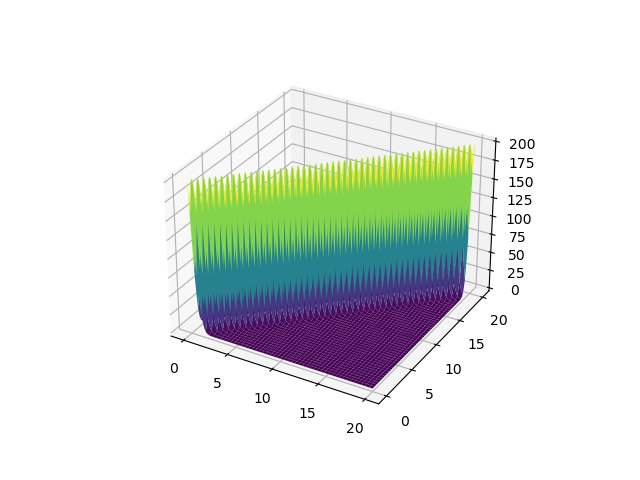

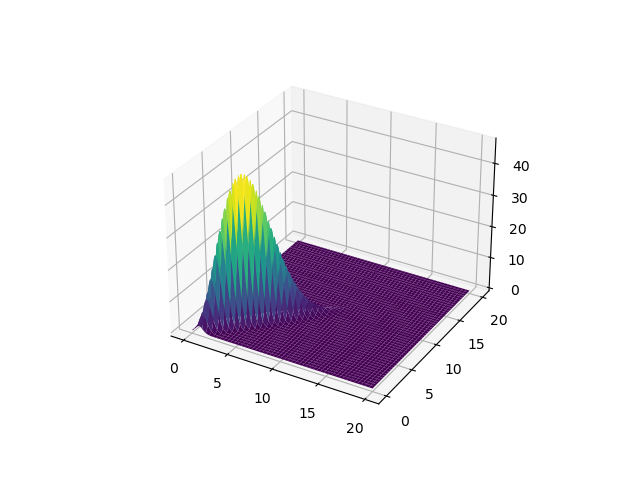

In [11]:
# Plot the potential grid
%matplotlib widget
#plt.matshow(np.log(pot))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r, rprime, pot, cmap='viridis', edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(r, rprime, (r**2 * pot * rfunc_1 * rfunc_3), cmap='viridis', edgecolor='none')
# Set limits on the axes
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 5)

In [9]:
# Plot the wavefunctions
# plt.figure()
# plt.plot(r[:,0], r[:,0]**2 * rfunc_1**2)
# plt.show()

In [24]:
def central_potential_reduced_matrix_element(wavefunctions, V0, mu, n1, l1, n2, l2, integration_limit, integration_steps):
    r = np.linspace(0, integration_limit, integration_steps)
    # We can compute the reduced matrix element as given by Moshinsky:

    rfunc_1 = wavefunctions[n1, l1, :]
    rfunc_2 = wavefunctions[n2, l2, :]

    # If rfunc is full of zeros, complain (stupid numba does not support string formatting OR error handling)
    if np.all(rfunc_1 == 0):
        print("rfunc1 is all zeros. n1, l1:", n1, l1)
    if np.all(rfunc_2 == 0):
        print("rfunc2 is all zeros. n2, l2:", n2, l2)

    pot = V0 * np.exp(-mu * r**2)
    
    plt.figure()
    plt.plot(r, pot)
    #plt.plot(r, rfunc_1 * rfunc_2 * r**2 * pot)

    return np.trapz(r**2 * rfunc_1 * pot * rfunc_2, r)

0.08199730840419216

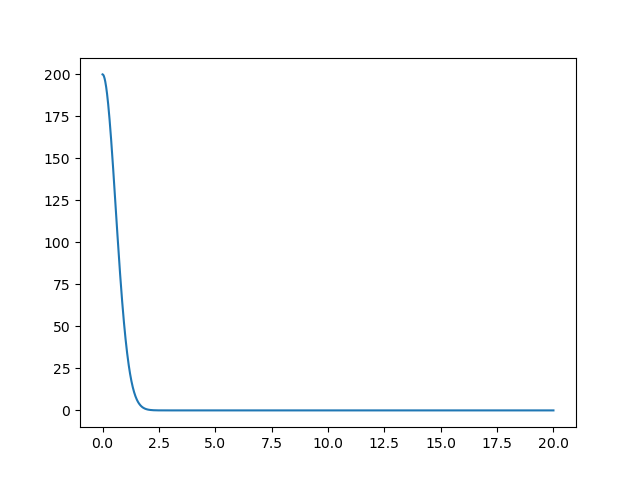

In [25]:
central_potential_reduced_matrix_element(wfs, V0, mu, n1, l1, n2, l2, integration_limit, integration_steps)